In [589]:
import pygal
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lars, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor, SGDClassifier

pd.set_option("max_columns", 500)
pd.set_option('display.float_format', lambda x: "{:,.2f}".format(x))

### PAY_AMT1

In [590]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/train_PAY_AMT1.csv")

In [591]:
df = df.rename(columns={"PAY_0": "PAY_1"})
df.drop(columns=["PAY_1"], inplace = True)

In [592]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [593]:
ls_disc = ["PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "SEX", "EDUCATION", "MARRIAGE",]
ls_cont = ["LIMIT_BAL", "AGE", "BILL_AMT2", "BILL_AMT3", 
           "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", 
           "PAY_AMT5", "PAY_AMT6"]
ls_banned = ["ID"]
target = "PAY_AMT1"

In [594]:
df["SEX"] = df["SEX"].map({1: "male", 2: "female"})
df["MARRIAGE"] = df["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
df["EDUCATION"] = df["EDUCATION"].map({1: "graduate school", 2: "university",
                     3: "high school", 4: "others", 5: "unknown",
                     6: "unknown"})
education_fill = df["EDUCATION"].mode()[0]
df["EDUCATION"] = df["EDUCATION"].fillna(education_fill)
for i in range(1, 7):
    if i == 1:
        continue
    df[f"PAY_{i}"] = df[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                     -1: "pay duly", 
                                                     0: "use",
                                         1: "payment delay for 1 months", 
                                         2: "payment delay for 2 months", 
                                         3: "payment delay for 3 months", 
                                         4: "payment delay for 4 months", 
                                         5: "payment delay for 5 months",
                                         6: "payment delay for 6 months", 
                                         7: "payment delay for 7 months", 
                                         8: "payment delay for 8 months", 
                                         9: "payment delay for 9+ months", })
    print(f"************************ PAY_{i} ***********************")
    print(df[f"PAY_{i}"].value_counts(True))

************************ PAY_2 ***********************
use                          0.53
pay duly                     0.20
payment delay for 2 months   0.13
Non use                      0.13
payment delay for 3 months   0.01
payment delay for 4 months   0.00
payment delay for 1 months   0.00
payment delay for 5 months   0.00
payment delay for 7 months   0.00
payment delay for 6 months   0.00
payment delay for 8 months   0.00
Name: PAY_2, dtype: float64
************************ PAY_3 ***********************
use                          0.53
pay duly                     0.20
Non use                      0.14
payment delay for 2 months   0.13
payment delay for 3 months   0.01
payment delay for 4 months   0.00
payment delay for 6 months   0.00
payment delay for 7 months   0.00
payment delay for 5 months   0.00
payment delay for 1 months   0.00
payment delay for 8 months   0.00
Name: PAY_3, dtype: float64
************************ PAY_4 ***********************
use                          0.

In [595]:
def normalize_pay(text):
    if text in ["use", "pay duly", "Non use", "payment delay for 2 months"]:
        return text
    else:
        return "Others"

In [596]:
for i in range(1, 7):
    if i == 1:
        continue
    df[f"PAY_{i}"] = df[f"PAY_{i}"].map(normalize_pay)
    print(f"************************ PAY_{i} ***********************")
    print(df[f"PAY_{i}"].value_counts(True))

************************ PAY_2 ***********************
use                          0.53
pay duly                     0.20
payment delay for 2 months   0.13
Non use                      0.13
Others                       0.02
Name: PAY_2, dtype: float64
************************ PAY_3 ***********************
use                          0.53
pay duly                     0.20
Non use                      0.14
payment delay for 2 months   0.13
Others                       0.01
Name: PAY_3, dtype: float64
************************ PAY_4 ***********************
use                          0.55
pay duly                     0.19
Non use                      0.14
payment delay for 2 months   0.11
Others                       0.01
Name: PAY_4, dtype: float64
************************ PAY_5 ***********************
use                          0.56
pay duly                     0.18
Non use                      0.15
payment delay for 2 months   0.09
Others                       0.01
Name: PAY_5, dty

In [597]:
df[ls_cont+[target]].describe([0.01, 0.02, 0.03, 0.04, 0.05, 0.95, 0.96, 0.97, 0.98, 0.99])

,LIMIT_BAL,AGE,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_AMT1
count,"21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00"
mean,"168,328.56",35.51,"49,174.59","46,956.18","43,354.89","40,317.88","38,973.93","5,983.07","5,363.61","4,836.75","4,923.01","5,274.33","5,621.36"
std,"130,400.80",9.20,"71,134.60","69,506.04","64,370.48","60,598.62","59,554.05","23,696.15","17,893.66","15,325.62","15,920.33","17,622.09","15,866.53"
min,"10,000.00",21.00,"-69,777.00","-157,264.00","-81,334.00","-61,372.00","-209,051.00",0.00,0.00,0.00,0.00,0.00,0.00
1%,"10,000.00",22.00,-189.02,-191.08,-200.00,-220.02,-304.03,0.00,0.00,0.00,0.00,0.00,0.00
2%,"20,000.00",22.00,-3.00,-3.00,-3.00,-3.00,-6.00,0.00,0.00,0.00,0.00,0.00,0.00
3%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"140,000.00",34.00,"21,021.50","19,929.50","19,029.50","18,139.50","17,150.00","2,021.00","1,855.00","1,500.00","1,500.00","1,500.00","2,119.00"


In [598]:
df = df[(df["LIMIT_BAL"] <= 5*10**5) & 
        (df["BILL_AMT3"] <= 322032.45) & 
        (df["PAY_AMT2"] <= 75865.60) & 
        (df["PAY_AMT3"] <= 74864.7) & 
        (df["PAY_AMT4"] <= 69246.19) & 
        (df["PAY_AMT5"] <= 70000.27) & 
        (df["PAY_AMT6"] <= 85750.7) & 
        (df["PAY_AMT1"] <= 55000)].reset_index(drop = True)

In [599]:
df.shape[0] / 21000

0.935047619047619

In [600]:
X = df[ls_disc+ls_cont]
y = df[[target]]

Limpieza de datos

#### Ingeniería de variables 

In [601]:
for i in range(2, 7):
    X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
    X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [602]:
%%time
for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
    for i in range(3, 7):
        time_widow = [f"{feat}{x}" for x in range(2, i+1)]
        for agg_f in ["mean", "min", "max", "median"]:
            X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)

CPU times: user 317 ms, sys: 0 ns, total: 317 ms
Wall time: 316 ms


In [603]:
def etl_cont_pay1(X):
    for i in range(2, 7):
        X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
        X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]
    for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
        for i in range(3, 7):
            time_widow = [f"{feat}{x}" for x in range(2, i+1)]
            for agg_f in ["mean", "min", "max", "median"]:
                X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)
    return X

def etl_disc_pay1(X):
    df["SEX"] = df["SEX"].map({1: "male", 2: "female"})
    df["MARRIAGE"] = df["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
    df["EDUCATION"] = df["EDUCATION"].map({1: "graduate school", 2: "university",
                         3: "high school", 4: "others", 5: "unknown",
                         6: "unknown"})
    df["EDUCATION"] = df["EDUCATION"].fillna(education_fill)
    for i in range(1, 7):
        if i == 1:
            continue
        X[f"PAY_{i}"] = X[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                         -1: "pay duly", 
                                                         0: "use",
                                             1: "payment delay for 1 months", 
                                             2: "payment delay for 2 months", 
                                             3: "payment delay for 3 months", 
                                             4: "payment delay for 4 months", 
                                             5: "payment delay for 5 months",
                                             6: "payment delay for 6 months", 
                                             7: "payment delay for 7 months", 
                                             8: "payment delay for 8 months", 
                                             9: "payment delay for 9+ months", })
        X[f"PAY_{i}"] = X[f"PAY_{i}"].map(normalize_pay)
    X = X.join(pd.get_dummies(X[ls_disc])).drop(columns=ls_disc)
    return X

In [607]:
X = X.join(pd.get_dummies(X[ls_disc])).drop(columns=ls_disc)

In [608]:
X

,LIMIT_BAL,AGE,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PCT_USE2,PCT_PAY2,PCT_USE3,PCT_PAY3,PCT_USE4,PCT_PAY4,PCT_USE5,PCT_PAY5,PCT_USE6,PCT_PAY6,PCT_USE_l3_mean,PCT_USE_l3_min,PCT_USE_l3_max,PCT_USE_l3_median,PCT_USE_l4_mean,PCT_USE_l4_min,PCT_USE_l4_max,PCT_USE_l4_median,PCT_USE_l5_mean,PCT_USE_l5_min,PCT_USE_l5_max,PCT_USE_l5_median,PCT_USE_l6_mean,PCT_USE_l6_min,PCT_USE_l6_max,PCT_USE_l6_median,PAY_AMT_l3_mean,PAY_AMT_l3_min,PAY_AMT_l3_max,PAY_AMT_l3_median,PAY_AMT_l4_mean,PAY_AMT_l4_min,PAY_AMT_l4_max,PAY_AMT_l4_median,PAY_AMT_l5_mean,PAY_AMT_l5_min,PAY_AMT_l5_max,PAY_AMT_l5_median,PAY_AMT_l6_mean,PAY_AMT_l6_min,PAY_AMT_l6_max,PAY_AMT_l6_median,PCT_PAY_l3_mean,PCT_PAY_l3_min,PCT_PAY_l3_max,PCT_PAY_l3_median,PCT_PAY_l4_mean,PCT_PAY_l4_min,PCT_PAY_l4_max,PCT_PAY_l4_median,PCT_PAY_l5_mean,PCT_PAY_l5_min,PCT_PAY_l5_max,PCT_PAY_l5_median,PCT_PAY_l6_mean,PCT_PAY_l6_min,PCT_PAY_l6_max,PCT_PAY_l6_median,PAY_2_Non use,PAY_2_Others,PAY_2_pay duly,PAY_2_payment delay for 2 months,PAY_2_use,PAY_3_Non use,PAY_3_Others,PAY_3_pay duly,PAY_3_payment delay for 2 months,PAY_3_use,PAY_4_Non use,PAY_4_Others,PAY_4_pay duly,PAY_4_payment delay for 2 months,PAY_4_use,PAY_5_Non use,PAY_5_Others,PAY_5_pay duly,PAY_5_payment delay for 2 months,PAY_5_use,PAY_6_Non use,PAY_6_Others,PAY_6_pay duly,PAY_6_payment delay for 2 months,PAY_6_use,SEX_female,SEX_male,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_others,EDUCATION_university,EDUCATION_unknown,MARRIAGE_married,MARRIAGE_others,MARRIAGE_single
0,"200,000.00",27,"18,382.00","18,834.00",0.00,0.00,0.00,"18,834.00","60,000.00",0.00,0.00,0.00,0.09,0.09,0.09,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.09,0.09,0.09,0.06,0.00,0.09,0.09,0.05,0.00,0.09,0.05,0.04,0.00,0.09,0.00,"39,417.00","18,834.00","60,000.00","39,417.00","26,278.00",0.00,"60,000.00","18,834.00","19,708.50",0.00,"60,000.00","9,417.00","15,766.80",0.00,"60,000.00",0.00,0.20,0.09,0.30,0.20,0.13,0.00,0.30,0.09,0.10,0.00,0.30,0.05,0.08,0.00,0.30,0.00,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1,"50,000.00",32,"46,117.00","46,919.00","17,459.00","17,825.00","18,193.00","3,000.00",625.00,647.00,664.00,649.00,0.92,0.06,0.94,0.01,0.35,0.01,0.36,0.01,0.36,0.01,0.93,0.92,0.94,0.93,0.74,0.35,0.94,0.92,0.64,0.35,0.94,0.64,0.59,0.35,0.94,0.36,"1,812.50",625.00,"3,000.00","1,812.50","1,424.00",625.00,"3,000.00",647.00,"1,234.00",625.00,"3,000.00",655.50,"1,117.00",625.00,"3,000.00",649.00,0.04,0.01,0.06,0.04,0.03,0.01,0.06,0.01,0.02,0.01,0.06,0.01,0.02,0.01,0.06,0.01,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0
2,"50,000.00",29,"21,466.00","23,122.00","24,654.00","26,365.00","25,844.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00",0.43,0.04,0.46,0.04,0.49,0.04,0.53,0.04,0.52,0.04,0.45,0.43,0.46,0.45,0.46,0.43,0.49,0.46,0.48,0.43,0.53,0.48,0.49,0.43,0.53,0.49,"2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00","2,000.00",0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0
3,"100,000.00",28,"9,089.00","13,534.00","16,158.00","6,700.00","7,730.00","6,000.00","4,375.00","6,700.00","3,000.00",0.00,0.09,0.06,0.14,0.04,0.16,0.07,0.07,0.03,0.08,0.00,0.11,0.09,0.14,0.11,0.13,0.09,0.16,0.14,0.11,0.07,0.16,0.11,0.11,0.07,0.16,0.09,"5,187.50","4,375.00","6,000.00","5,187.50","5,691.67","4,375.00","6,700.00","6,000.00","5,018.75","3,000.00","6,700.00","5,187.50","4,015.00",0.00,"6,700.00","4,375.00",0.05,0.04,0.06,0.05,0.06,0.04,0.07,0.06,0.05,0.03,0.07,0.05,0.04,0.00,0.07,0.04,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
4,"20,000.00",46,"2,901.00","3,800.00",0.00,0.00,0.00,"1,000.00",0.00,0.00,0.00,0.00,0.15,0.05,0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.15,0.19,0.17,0.11,0.00,0.19,0.15,0.08,0.00,0.19

In [609]:
ls_cont = X.columns

In [610]:
linreg = Ridge(alpha = 0, solver="sparse_cg")

In [611]:
param_grid = {
    "alpha": [x for x in range(10, 1000, 10)] + [y/10 for y in range(10)],
    "tol": [0.00001],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [612]:
hp = RandomizedSearchCV(cv=4, 
                        n_iter=10,
                        param_distributions=param_grid,
                        scoring="r2", 
                  verbose=10,
                  error_score=-1000, 
                  estimator=linreg, 
                  n_jobs=-1, 
                 )

In [613]:
hp.fit(X, y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  1.2min remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


RandomizedSearchCV(cv=4, error_score=-1000,
          estimator=Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='sparse_cg', tol=0.001),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'alpha': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560....8, 0.9], 'tol': [1e-05], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='r2', verbose=10)

In [614]:
hp.best_score_

0.3644675214659013

In [615]:
hp.best_estimator_

Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=1e-05)

In [616]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/val_PAY_AMT1.csv")

In [617]:
df = etl_cont_pay1(df)

In [618]:
df = etl_disc_pay1(df)

In [619]:
df = df[X.columns.tolist() + ["ID"]]

In [622]:
df["y_hat"] = hp.best_estimator_.predict(df[X.columns])

In [29]:
df[["ID", "y_hat"]].to_csv("val_PAY_AMT1_profe.csv")

### PAY_AMT2

In [624]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/train_PAY_AMT2.csv")
df.drop(columns=["PAY_2", "PAY_0"], inplace = True)

In [625]:
ls_disc = ["PAY_3", "PAY_4", "PAY_5", "PAY_6", "SEX", "EDUCATION", "MARRIAGE",]
ls_cont = ["LIMIT_BAL", "AGE", "BILL_AMT2", "BILL_AMT3", 
           "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT3", "PAY_AMT4", 
           "PAY_AMT5", "PAY_AMT6"]
ls_banned = ["ID"]
target = "PAY_AMT2"

In [626]:
df["SEX"] = df["SEX"].map({1: "male", 2: "female"})
df["MARRIAGE"] = df["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
df["EDUCATION"] = df["EDUCATION"].map({1: "graduate school", 2: "university",
                     3: "high school", 4: "others", 5: "unknown",
                     6: "unknown"})
education_fill = df["EDUCATION"].mode()[0]
df["EDUCATION"] = df["EDUCATION"].fillna(education_fill)
for i in range(3, 7):
    df[f"PAY_{i}"] = df[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                     -1: "pay duly", 
                                                     0: "use",
                                         1: "payment delay for 1 months", 
                                         2: "payment delay for 2 months", 
                                         3: "payment delay for 3 months", 
                                         4: "payment delay for 4 months", 
                                         5: "payment delay for 5 months",
                                         6: "payment delay for 6 months", 
                                         7: "payment delay for 7 months", 
                                         8: "payment delay for 8 months", 
                                         9: "payment delay for 9+ months", })

In [34]:
for i in range(3, 7):
    df[f"PAY_{i}"] = df[f"PAY_{i}"].map(normalize_pay)

In [627]:
df[ls_cont+[target]].describe([0.01, 0.02, 0.03, 0.04, 0.05, 0.95, 0.96, 0.97, 0.98, 0.99])

,LIMIT_BAL,AGE,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_AMT2
count,"21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00"
mean,"168,328.56",35.51,"49,174.59","46,956.18","43,354.89","40,317.88","38,973.93","5,363.61","4,836.75","4,923.01","5,274.33","5,983.07"
std,"130,400.80",9.20,"71,134.60","69,506.04","64,370.48","60,598.62","59,554.05","17,893.66","15,325.62","15,920.33","17,622.09","23,696.15"
min,"10,000.00",21.00,"-69,777.00","-157,264.00","-81,334.00","-61,372.00","-209,051.00",0.00,0.00,0.00,0.00,0.00
1%,"10,000.00",22.00,-189.02,-191.08,-200.00,-220.02,-304.03,0.00,0.00,0.00,0.00,0.00
2%,"20,000.00",22.00,-3.00,-3.00,-3.00,-3.00,-6.00,0.00,0.00,0.00,0.00,0.00
3%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"140,000.00",34.00,"21,021.50","19,929.50","19,029.50","18,139.50","17,150.00","1,855.00","1,500.00","1,500.00","1,500.00","2,021.00"


In [628]:
df = df[(df["LIMIT_BAL"] <= 5*10**5) & 
        (df["BILL_AMT3"] <= 322032.45) & 
        (df["PAY_AMT3"] <= 74864.7) & 
        (df["PAY_AMT4"] <= 69246.19) & 
        (df["PAY_AMT5"] <= 70000.27) & 
        (df["PAY_AMT6"] <= 85750.7) & 
        (df["PAY_AMT2"] <= 76656.47)].reset_index(drop = True)

In [629]:
df.shape[0] / 21000

0.9445714285714286

In [630]:
X = df[ls_disc+ls_cont]
y = df[[target]]

In [631]:
for i in range(3, 7):
    X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
    X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [632]:
%%time
for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
    for i in range(4, 7):
        time_widow = [f"{feat}{x}" for x in range(3, i+1)]
        for agg_f in ["mean", "min", "max", "median"]:
            X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)

CPU times: user 162 ms, sys: 7.94 ms, total: 170 ms
Wall time: 172 ms


In [633]:
def etl_cont_pay2(X):
    for i in range(3, 7):
        X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
        X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]
    for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
        for i in range(3, 7):
            time_widow = [f"{feat}{x}" for x in range(3, i+1)]
            for agg_f in ["mean", "min", "max", "median"]:
                X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)
    return X

def etl_disc_pay2(X):
    df["SEX"] = df["SEX"].map({1: "male", 2: "female"})
    df["MARRIAGE"] = df["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
    df["EDUCATION"] = df["EDUCATION"].map({1: "graduate school", 2: "university",
                         3: "high school", 4: "others", 5: "unknown",
                         6: "unknown"})
    df["EDUCATION"] = df["EDUCATION"].fillna(education_fill)
    for i in range(3, 7):
        X[f"PAY_{i}"] = X[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                         -1: "pay duly", 
                                                         0: "use",
                                             1: "payment delay for 1 months", 
                                             2: "payment delay for 2 months", 
                                             3: "payment delay for 3 months", 
                                             4: "payment delay for 4 months", 
                                             5: "payment delay for 5 months",
                                             6: "payment delay for 6 months", 
                                             7: "payment delay for 7 months", 
                                             8: "payment delay for 8 months", 
                                             9: "payment delay for 9+ months", })
        X[f"PAY_{i}"] = X[f"PAY_{i}"].map(normalize_pay)
    X = X.join(pd.get_dummies(X[ls_disc])).drop(columns=ls_disc)
    return X

In [634]:
X = X.join(pd.get_dummies(X[ls_disc])).drop(columns=ls_disc)

In [635]:
param_grid = {
    "alpha": [x for x in range(10, 1000, 10)] + [y/10 for y in range(10)],
    "tol": [0.00001],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [636]:
hp = RandomizedSearchCV(cv=4, 
                        n_iter=10,
                        param_distributions=param_grid,
                        scoring="r2", 
                  verbose=10,
                  error_score=-1000, 
                  estimator=linreg, 
                  n_jobs=-1, 
                 )

In [637]:
hp.fit(X, y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  1.3min remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


RandomizedSearchCV(cv=4, error_score=-1000,
          estimator=Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='sparse_cg', tol=0.001),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'alpha': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560....8, 0.9], 'tol': [1e-05], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='r2', verbose=10)

In [639]:
hp.best_score_

0.3508294278474522

In [640]:
hp.best_estimator_

Ridge(alpha=0.6, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=1e-05)

In [645]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/val_PAY_AMT2.csv")

In [646]:
df = etl_cont_pay2(df)

In [647]:
df = etl_disc_pay2(df)

In [648]:
df = df[X.columns.tolist() + ["ID"]]

KeyError: "['PAY_5_payment delay for 8 months', 'PAY_4_payment delay for 7 months', 'PAY_3_payment delay for 3 months', 'PAY_4_payment delay for 3 months', 'PAY_3_payment delay for 5 months', 'PAY_5_payment delay for 5 months', 'PAY_6_payment delay for 8 months', 'PAY_6_payment delay for 5 months', 'PAY_5_payment delay for 7 months', 'PAY_3_payment delay for 8 months', 'PAY_5_payment delay for 4 months', 'PAY_3_payment delay for 4 months', 'PAY_4_payment delay for 5 months', 'PAY_4_payment delay for 4 months', 'PAY_6_payment delay for 3 months', 'PAY_4_payment delay for 6 months', 'PAY_4_payment delay for 8 months', 'PAY_3_payment delay for 1 months', 'PAY_5_payment delay for 6 months', 'PAY_6_payment delay for 6 months', 'PAY_3_payment delay for 7 months', 'PAY_3_payment delay for 6 months', 'PAY_6_payment delay for 7 months', 'PAY_6_payment delay for 4 months', 'PAY_5_payment delay for 3 months'] not in index"

In [52]:
df["y_hat"] = hp.best_estimator_.predict(df[X.columns])

In [53]:
df[["ID", "y_hat"]].to_csv("val_PAY_AMT2_profe.csv")

### PAY_AMT3

In [649]:
total = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/datasets/UCI_Credit_Card.csv")

In [55]:
df = df.merge(total[["ID", "BILL_AMT3"]], on = "ID", how = "left")

In [650]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/train_PAY_AMT3.csv")
df.drop(columns=["PAY_3", "PAY_0", "PAY_AMT1", "PAY_AMT2", "PAY_2"], inplace = True)

In [651]:
ls_disc = ["PAY_4", "PAY_5", "PAY_6", "SEX", "EDUCATION", "MARRIAGE",]
ls_cont = ["LIMIT_BAL", "AGE", "BILL_AMT3", 
           "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT4", 
           "PAY_AMT5", "PAY_AMT6"]
ls_banned = ["ID"]
target = "PAY_AMT3"

In [652]:
df["SEX"] = df["SEX"].map({1: "male", 2: "female"})
df["MARRIAGE"] = df["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
df["EDUCATION"] = df["EDUCATION"].map({1: "graduate school", 2: "university",
                     3: "high school", 4: "others", 5: "unknown",
                     6: "unknown"})
education_fill = df["EDUCATION"].mode()[0]
df["EDUCATION"] = df["EDUCATION"].fillna(education_fill)
for i in range(4, 7):
    df[f"PAY_{i}"] = df[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                     -1: "pay duly", 
                                                     0: "use",
                                         1: "payment delay for 1 months", 
                                         2: "payment delay for 2 months", 
                                         3: "payment delay for 3 months", 
                                         4: "payment delay for 4 months", 
                                         5: "payment delay for 5 months",
                                         6: "payment delay for 6 months", 
                                         7: "payment delay for 7 months", 
                                         8: "payment delay for 8 months", 
                                         9: "payment delay for 9+ months", })

In [653]:
for i in range(4, 7):
    df[f"PAY_{i}"] = df[f"PAY_{i}"].map(normalize_pay)

In [654]:
df[ls_cont+[target]].describe([0.01, 0.02, 0.03, 0.04, 0.05, 0.95, 0.96, 0.97, 0.98, 0.99])

,LIMIT_BAL,AGE,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_AMT3
count,"21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00"
mean,"168,328.56",35.51,"46,956.18","43,354.89","40,317.88","38,973.93","4,836.75","4,923.01","5,274.33","5,363.61"
std,"130,400.80",9.20,"69,506.04","64,370.48","60,598.62","59,554.05","15,325.62","15,920.33","17,622.09","17,893.66"
min,"10,000.00",21.00,"-157,264.00","-81,334.00","-61,372.00","-209,051.00",0.00,0.00,0.00,0.00
1%,"10,000.00",22.00,-191.08,-200.00,-220.02,-304.03,0.00,0.00,0.00,0.00
2%,"20,000.00",22.00,-3.00,-3.00,-3.00,-6.00,0.00,0.00,0.00,0.00
3%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"140,000.00",34.00,"19,929.50","19,029.50","18,139.50","17,150.00","1,500.00","1,500.00","1,500.00","1,855.00"


In [655]:
df = df[(df["LIMIT_BAL"] <= 5*10**5) & 
        (df["BILL_AMT3"] <= 322032.45) & 
        (df["PAY_AMT4"] <= 69246.19) & 
        (df["PAY_AMT5"] <= 70000.27) & 
        (df["PAY_AMT6"] <= 85750.7) & 
        (df["PAY_AMT3"] <= 74864.7)].reset_index(drop = True)

In [656]:
df.shape[0] / 21000

0.9515238095238095

In [657]:
X = df[ls_disc+ls_cont]
y = df[[target]]

In [658]:
for i in range(4, 7):
    X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
    X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [659]:
%%time
for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
    for i in range(4, 7):
        time_widow = [f"{feat}{x}" for x in range(4, i+1)]
        for agg_f in ["mean", "min", "max", "median"]:
            X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)

CPU times: user 198 ms, sys: 7.99 ms, total: 206 ms
Wall time: 206 ms


In [660]:
def etl_cont_pay2(X):
    for i in range(4, 7):
        X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
        X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]
    for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
        for i in range(4, 7):
            time_widow = [f"{feat}{x}" for x in range(4, i+1)]
            for agg_f in ["mean", "min", "max", "median"]:
                X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)
    return X

def etl_disc_pay2(X):
    df["SEX"] = df["SEX"].map({1: "male", 2: "female"})
    df["MARRIAGE"] = df["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
    df["EDUCATION"] = df["EDUCATION"].map({1: "graduate school", 2: "university",
                         3: "high school", 4: "others", 5: "unknown",
                         6: "unknown"})
    df["EDUCATION"] = df["EDUCATION"].fillna(education_fill)
    for i in range(4, 7):
        X[f"PAY_{i}"] = X[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                         -1: "pay duly", 
                                                         0: "use",
                                             1: "payment delay for 1 months", 
                                             2: "payment delay for 2 months", 
                                             3: "payment delay for 3 months", 
                                             4: "payment delay for 4 months", 
                                             5: "payment delay for 5 months",
                                             6: "payment delay for 6 months", 
                                             7: "payment delay for 7 months", 
                                             8: "payment delay for 8 months", 
                                             9: "payment delay for 9+ months", })
        X[f"PAY_{i}"] = X[f"PAY_{i}"].map(normalize_pay)
    X = X.join(pd.get_dummies(X[ls_disc])).drop(columns=ls_disc)
    return X

In [661]:
X = X.join(pd.get_dummies(X[ls_disc])).drop(columns=ls_disc)

In [662]:
param_grid = {
    "alpha": [x for x in range(10, 1000, 10)] + [y/10 for y in range(10)],
    "tol": [0.00001],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [663]:
hp = RandomizedSearchCV(cv=4, 
                        n_iter=10,
                        param_distributions=param_grid,
                        scoring="r2", 
                  verbose=10,
                  error_score=-1000, 
                  estimator=linreg, 
                  n_jobs=-1, 
                 )

In [664]:
hp.fit(X, y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  1.5min remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished


RandomizedSearchCV(cv=4, error_score=-1000,
          estimator=Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='sparse_cg', tol=0.001),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'alpha': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560....8, 0.9], 'tol': [1e-05], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='r2', verbose=10)

In [665]:
hp.best_score_

0.33465776704968775

In [666]:
hp.best_estimator_

Ridge(alpha=540, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=1e-05)

In [667]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/val_PAY_AMT3.csv")

In [668]:
df = etl_cont_pay2(df)

In [669]:
df = etl_disc_pay2(df)

In [670]:
df = df[X.columns.tolist() + ["ID"]]

In [671]:
df["y_hat"] = hp.best_estimator_.predict(df[X.columns])

In [672]:
df[["ID", "y_hat"]].to_csv("val_PAY_AMT3_profe.csv")

### Clasificadores

In [673]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/train_default.csv")
df.rename(columns={"PAY_0": "PAY_1"}, inplace=True)

In [674]:
ls_disc = ["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "SEX", "EDUCATION", "MARRIAGE",]
ls_cont = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", 
           "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", 
           "PAY_AMT5", "PAY_AMT6"]
ls_banned = ["ID"]
target = "default.payment.next.month"

In [675]:
df["SEX"] = df["SEX"].map({1: "male", 2: "female"})
df["MARRIAGE"] = df["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
df["EDUCATION"] = df["EDUCATION"].map({1: "graduate school", 2: "university",
                     3: "high school", 4: "others", 5: "unknown",
                     6: "unknown"})
education_fill = df["EDUCATION"].mode()[0]
df["EDUCATION"] = df["EDUCATION"].fillna(education_fill)
for i in range(1, 7):
    df[f"PAY_{i}"] = df[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                     -1: "pay duly", 
                                                     0: "use",
                                         1: "payment delay for 1 months", 
                                         2: "payment delay for 2 months", 
                                         3: "payment delay for 3 months", 
                                         4: "payment delay for 4 months", 
                                         5: "payment delay for 5 months",
                                         6: "payment delay for 6 months", 
                                         7: "payment delay for 7 months", 
                                         8: "payment delay for 8 months", 
                                         9: "payment delay for 9+ months", })

In [676]:
for i in range(1, 7):
    df[f"PAY_{i}"] = df[f"PAY_{i}"].map(normalize_pay)

In [677]:
df[ls_cont].describe([0.01, 0.02, 0.03, 0.04, 0.05, 0.95, 0.96, 0.97, 0.98, 0.99])

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,"21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00"
mean,"168,328.56",35.51,"51,252.37","49,174.59","46,956.18","43,354.89","40,317.88","38,973.93","5,621.36","5,983.07","5,363.61","4,836.75","4,923.01","5,274.33"
std,"130,400.80",9.20,"73,444.62","71,134.60","69,506.04","64,370.48","60,598.62","59,554.05","15,866.53","23,696.15","17,893.66","15,325.62","15,920.33","17,622.09"
min,"10,000.00",21.00,"-165,580.00","-69,777.00","-157,264.00","-81,334.00","-61,372.00","-209,051.00",0.00,0.00,0.00,0.00,0.00,0.00
1%,"10,000.00",22.00,-65.01,-189.02,-191.08,-200.00,-220.02,-304.03,0.00,0.00,0.00,0.00,0.00,0.00
2%,"20,000.00",22.00,0.00,-3.00,-3.00,-3.00,-3.00,-6.00,0.00,0.00,0.00,0.00,0.00,0.00
3%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"140,000.00",34.00,"22,379.00","21,021.50","19,929.50","19,029.50","18,139.50","17,150.00","2,119.00","2,021.00","1,855.00","1,500.00","1,500.00","1,500.00"


In [678]:
df = df[(df["LIMIT_BAL"] <= 5*10**5) & 
        (df["BILL_AMT3"] <= 322032.45) & 
        (df["PAY_AMT2"] <= 75865.60) & 
        (df["PAY_AMT3"] <= 74864.7) & 
        (df["PAY_AMT4"] <= 69246.19) & 
        (df["PAY_AMT5"] <= 70000.27) & 
        (df["PAY_AMT6"] <= 85750.7) & 
        (df["PAY_AMT1"] <= 55000)].reset_index(drop = True)

In [679]:
df.shape[0] / 21000

0.935047619047619

In [680]:
X = df[ls_disc+ls_cont]
y = df[[target]]

In [681]:
for i in range(1, 7):
    X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
    X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [682]:
%%time
for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
    for i in range(1, 7):
        time_widow = [f"{feat}{x}" for x in range(1, i+1)]
        for agg_f in ["mean", "min", "max", "median"]:
            X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)

CPU times: user 519 ms, sys: 7.95 ms, total: 527 ms
Wall time: 526 ms


In [684]:
def etl_cont_pay_default(X):
    for i in range(1, 7):
        X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
        X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]
    for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
        for i in range(1, 7):
            time_widow = [f"{feat}{x}" for x in range(1, i+1)]
            for agg_f in ["mean", "min", "max", "median"]:
                X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)
    return X

def etl_disc_pay_default(X):
    X.rename(columns={"PAY_0": "PAY_1"}, inplace=True)
    X["SEX"] = X["SEX"].map({1: "male", 2: "female"})
    X["MARRIAGE"] = X["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
    X["EDUCATION"] = X["EDUCATION"].map({1: "graduate school", 2: "university",
                         3: "high school", 4: "others", 5: "unknown",
                         6: "unknown"})
    X["EDUCATION"] = X["EDUCATION"].fillna(education_fill)
    for i in range(1, 7):
        X[f"PAY_{i}"] = X[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                         -1: "pay duly", 
                                                         0: "use",
                                             1: "payment delay for 1 months", 
                                             2: "payment delay for 2 months", 
                                             3: "payment delay for 3 months", 
                                             4: "payment delay for 4 months", 
                                             5: "payment delay for 5 months",
                                             6: "payment delay for 6 months", 
                                             7: "payment delay for 7 months", 
                                             8: "payment delay for 8 months", 
                                             9: "payment delay for 9+ months", })
        X[f"PAY_{i}"] = X[f"PAY_{i}"].map(normalize_pay)
    X = X.join(pd.get_dummies(X[ls_disc])).drop(columns=ls_disc)
    return X

In [685]:
ls_cont = [x for x in X.columns if x not in ls_disc]

In [686]:
X = X.join(pd.get_dummies(X[ls_disc])).drop(columns=ls_disc)

In [688]:
logreg = LogisticRegression(n_jobs=-1)

In [689]:
logreg.fit(X, y)

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [690]:
ls_medias = cross_val_score(X=X, y=y, cv=4, estimator=logreg, n_jobs=-1, error_score=-1000, scoring="roc_auc")

In [692]:
np.mean(ls_medias), np.std(ls_medias)

(0.7014336624224573, 0.009214330153459857)

In [694]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/val_default.csv")

In [695]:
df = etl_cont_pay_default(df)

In [696]:
df = etl_disc_pay_default(df)

In [697]:
df = df[X.columns.tolist() + ["ID"]]

In [698]:
df["y_hat"] = logreg.predict(df[X.columns])

In [699]:
logreg.predict_proba(df[X.columns])

array([[0.82691571, 0.17308429],
       [0.77647976, 0.22352024],
       [0.99332722, 0.00667278],
       ...,
       [0.80069234, 0.19930766],
       [0.94413138, 0.05586862],
       [0.69029845, 0.30970155]])

In [700]:
df[["ID", "y_hat"]].to_csv("val_default_profe.csv")

## Credit Scoring

In [701]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/train_default.csv")
df.rename(columns={"PAY_0": "PAY_1"}, inplace=True)

In [702]:
ls_disc = ["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "SEX", "EDUCATION", "MARRIAGE",]
ls_cont = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", 
           "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", 
           "PAY_AMT5", "PAY_AMT6"]
ls_banned = ["ID"]
target = "default.payment.next.month"

In [703]:
df["SEX"] = df["SEX"].map({1: "male", 2: "female"})
df["MARRIAGE"] = df["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
df["EDUCATION"] = df["EDUCATION"].map({1: "graduate school", 2: "university",
                     3: "high school", 4: "others", 5: "unknown",
                     6: "unknown"})
education_fill = df["EDUCATION"].mode()[0]
df["EDUCATION"] = df["EDUCATION"].fillna(education_fill)
for i in range(1, 7):
    df[f"PAY_{i}"] = df[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                     -1: "pay duly", 
                                                     0: "use",
                                         1: "payment delay for 1 months", 
                                         2: "payment delay for 2 months", 
                                         3: "payment delay for 3 months", 
                                         4: "payment delay for 4 months", 
                                         5: "payment delay for 5 months",
                                         6: "payment delay for 6 months", 
                                         7: "payment delay for 7 months", 
                                         8: "payment delay for 8 months", 
                                         9: "payment delay for 9+ months", })

In [704]:
for i in range(1, 7):
    df[f"PAY_{i}"] = df[f"PAY_{i}"].map(normalize_pay)

In [705]:
df[ls_cont].describe([0.01, 0.02, 0.03, 0.04, 0.05, 0.95, 0.96, 0.97, 0.98, 0.99])

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,"21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00"
mean,"168,328.56",35.51,"51,252.37","49,174.59","46,956.18","43,354.89","40,317.88","38,973.93","5,621.36","5,983.07","5,363.61","4,836.75","4,923.01","5,274.33"
std,"130,400.80",9.20,"73,444.62","71,134.60","69,506.04","64,370.48","60,598.62","59,554.05","15,866.53","23,696.15","17,893.66","15,325.62","15,920.33","17,622.09"
min,"10,000.00",21.00,"-165,580.00","-69,777.00","-157,264.00","-81,334.00","-61,372.00","-209,051.00",0.00,0.00,0.00,0.00,0.00,0.00
1%,"10,000.00",22.00,-65.01,-189.02,-191.08,-200.00,-220.02,-304.03,0.00,0.00,0.00,0.00,0.00,0.00
2%,"20,000.00",22.00,0.00,-3.00,-3.00,-3.00,-3.00,-6.00,0.00,0.00,0.00,0.00,0.00,0.00
3%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,"20,000.00",23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"140,000.00",34.00,"22,379.00","21,021.50","19,929.50","19,029.50","18,139.50","17,150.00","2,119.00","2,021.00","1,855.00","1,500.00","1,500.00","1,500.00"


In [706]:
df = df[(df["LIMIT_BAL"] <= 5*10**5) & 
        (df["BILL_AMT3"] <= 322032.45) & 
        (df["PAY_AMT2"] <= 75865.60) & 
        (df["PAY_AMT3"] <= 74864.7) & 
        (df["PAY_AMT4"] <= 69246.19) & 
        (df["PAY_AMT5"] <= 70000.27) & 
        (df["PAY_AMT6"] <= 85750.7) & 
        (df["PAY_AMT1"] <= 55000)].reset_index(drop = True)

In [707]:
df.shape[0] / 21000

0.935047619047619

In [708]:
X = df[ls_disc+ls_cont]
y = df[[target]]

In [709]:
for i in range(1, 7):
    X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
    X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [710]:
%%time
for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
    for i in range(1, 7):
        time_widow = [f"{feat}{x}" for x in range(1, i+1)]
        for agg_f in ["mean", "min", "max", "median"]:
            X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)

CPU times: user 607 ms, sys: 3.99 ms, total: 611 ms
Wall time: 618 ms


In [711]:
def etl_cont_pay_default(X):
    for i in range(1, 7):
        X[f"PCT_USE{i}"] = X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]
        X[f"PCT_PAY{i}"] = X[f"PAY_AMT{i}"] / X["LIMIT_BAL"]
    for feat in ["PCT_USE", "PAY_AMT", "PCT_PAY"]:
        for i in range(1, 7):
            time_widow = [f"{feat}{x}" for x in range(1, i+1)]
            for agg_f in ["mean", "min", "max", "median"]:
                X[f"{feat}_l{i}_{agg_f}"] = X[time_widow].aggregate(agg_f, axis = 1)
    return X

def etl_disc_pay_default(X):
    X.rename(columns={"PAY_0": "PAY_1"}, inplace=True)
    X["SEX"] = X["SEX"].map({1: "male", 2: "female"})
    X["MARRIAGE"] = X["MARRIAGE"].map({1: "married", 2: "single", 3: "others"})
    X["EDUCATION"] = X["EDUCATION"].map({1: "graduate school", 2: "university",
                         3: "high school", 4: "others", 5: "unknown",
                         6: "unknown"})
    X["EDUCATION"] = X["EDUCATION"].fillna(education_fill)
    for i in range(1, 7):
        X[f"PAY_{i}"] = X[f"PAY_{i}"].astype(int).map({-2: "Non use",
                                                         -1: "pay duly", 
                                                         0: "use",
                                             1: "payment delay for 1 months", 
                                             2: "payment delay for 2 months", 
                                             3: "payment delay for 3 months", 
                                             4: "payment delay for 4 months", 
                                             5: "payment delay for 5 months",
                                             6: "payment delay for 6 months", 
                                             7: "payment delay for 7 months", 
                                             8: "payment delay for 8 months", 
                                             9: "payment delay for 9+ months", })
        X[f"PAY_{i}"] = X[f"PAY_{i}"].map(normalize_pay)
    return X

In [712]:
ls_cont = [x for x in X.columns if x not in ls_disc]

In [716]:
for var in ls_cont:
    X[f"C_{var}"] = pd.cut(X[var], bins=5).astype(str)

In [714]:
from sklearn.tree import DecisionTreeClassifier

In [715]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.05)

In [719]:
tree.fit(X = X[[var]], y=y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.05, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [722]:
tree.score(X[[var]], y)

0.7709309431656142

In [726]:
set(tree.apply(X[[var]]))

{1, 4, 7, 8, 9, 13, 14, 16, 17, 18}

In [727]:
def IV(df, var, tgt):
    aux = df[[var, tgt]].groupby(var).agg(["count", "sum"])
    aux["evento"] = aux[tgt, "sum"]
    aux["no_evento"] = aux[tgt, "count"] - aux[tgt, "sum"]
    aux["%evento"] = aux["evento"] / aux["evento"].sum()
    aux["%no_evento"] = aux["no_evento"] / aux["no_evento"].sum()
    aux["WOE"] = np.log(aux["%no_evento"] / aux["%evento"])
    aux["IV"] = (aux["%no_evento"] - aux["%evento"])*aux["WOE"]
    return aux["IV"].sum()

In [728]:
new_disc = [x for x in X.columns if x.startswith("C_")] + ls_disc
for col in new_disc:
    X[col] = X[col].fillna("Missing")

In [729]:
df_iv = pd.DataFrame(columns=["iv"])
for var in new_disc+ls_disc:
    df_iv.loc[var, "iv"] = IV(df = X.join(y), var = var, tgt = target)

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [731]:
df_iv[df_iv["iv"] != np.inf].sort_values(by = "iv", ascending=False)

,iv
PAY_1,0.84
PAY_2,0.53
PAY_3,0.40
PAY_4,0.36
PAY_5,0.33
PAY_6,0.27
C_LIMIT_BAL,0.13
C_PAY_AMT_l5_max,0.07
C_PAY_AMT_l3_max,0.07
C_PAY_AMT_l6_max,0.07


In [732]:
ls_best = df_iv[(df_iv["iv"] != np.inf) & (df_iv["iv"] >= 0.01)].index.tolist()

In [734]:
len(ls_best)

26

In [735]:
def WOE(df, var, tgt):
    aux = df[[var, tgt]].groupby(var).agg(["count", "sum"])
    aux["evento"] = aux[tgt, "sum"]
    aux["no_evento"] = aux[tgt, "count"] - aux[tgt, "sum"]
    aux["%evento"] = aux["evento"] / aux["evento"].sum()
    aux["%no_evento"] = aux["no_evento"] / aux["no_evento"].sum()
    aux["WOE"] = np.log(aux["%no_evento"] / aux["%evento"])
    aux.columns = aux.columns.droplevel(1)
    display(aux)
    aux = aux[["WOE"]].reset_index().rename(columns={"WOE": f"W_{var}"})
    df = df.merge(aux, on = var, how = "left")
    return df

In [737]:
X = X.join(y)

In [738]:
for col in ls_best:
    X = WOE(df = X, var = col, tgt = target)

,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_LIMIT_BAL,,,,,,,
"(108000.0, 206000.0]",5264,1054,1054,4210,0.23,0.28,0.17
"(206000.0, 304000.0]",3236,531,531,2705,0.12,0.18,0.41
"(304000.0, 402000.0]",1694,252,252,1442,0.06,0.10,0.53
"(402000.0, 500000.0]",840,111,111,729,0.02,0.05,0.67
"(9510.0, 108000.0]",8602,2550,2550,6052,0.57,0.40,-0.35


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT1,,,,,,,
"(-55.0, 11000.0]",18356,4338,4338,14018,0.96,0.93,-0.04
"(11000.0, 22000.0]",874,120,120,754,0.03,0.05,0.62
"(22000.0, 33000.0]",226,23,23,203,0.01,0.01,0.96
"(33000.0, 44000.0]",105,11,11,94,0.00,0.01,0.93
"(44000.0, 55000.0]",75,6,6,69,0.00,0.00,1.23


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT2,,,,,,,
"(-75.26, 15052.0]",18769,4428,4428,14341,0.98,0.95,-0.04
"(15052.0, 30104.0]",579,51,51,528,0.01,0.03,1.12
"(30104.0, 45156.0]",152,11,11,141,0.00,0.01,1.34
"(45156.0, 60208.0]",95,7,7,88,0.00,0.01,1.32
"(60208.0, 75260.0]",41,1,1,40,0.00,0.00,2.48


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT3,,,,,,,
"(-74.864, 14972.8]",18757,4402,4402,14355,0.98,0.95,-0.03
"(14972.8, 29945.6]",574,64,64,510,0.01,0.03,0.86
"(29945.6, 44918.4]",176,20,20,156,0.00,0.01,0.84
"(44918.4, 59891.2]",95,9,9,86,0.00,0.01,1.04
"(59891.2, 74864.0]",34,3,3,31,0.00,0.00,1.12


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT4,,,,,,,
"(-69.245, 13849.0]",18794,4392,4392,14402,0.98,0.95,-0.03
"(13849.0, 27698.0]",515,65,65,450,0.01,0.03,0.72
"(27698.0, 41547.0]",177,19,19,158,0.00,0.01,0.90
"(41547.0, 55396.0]",109,15,15,94,0.00,0.01,0.62
"(55396.0, 69245.0]",41,7,7,34,0.00,0.00,0.37


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT5,,,,,,,
"(-70.0, 14000.0]",18784,4405,4405,14379,0.98,0.95,-0.03
"(14000.0, 28000.0]",542,58,58,484,0.01,0.03,0.91
"(28000.0, 42000.0]",179,26,26,153,0.01,0.01,0.56
"(42000.0, 56000.0]",84,4,4,80,0.00,0.01,1.78
"(56000.0, 70000.0]",47,5,5,42,0.00,0.00,0.91


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT6,,,,,,,
"(-85.75, 17150.0]",18940,4415,4415,14525,0.98,0.96,-0.02
"(17150.0, 34300.0]",435,49,49,386,0.01,0.03,0.85
"(34300.0, 51450.0]",147,19,19,128,0.00,0.01,0.69
"(51450.0, 68600.0]",71,10,10,61,0.00,0.00,0.59
"(68600.0, 85750.0]",43,5,5,38,0.00,0.00,0.81


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l1_mean,,,,,,,
"(-55.0, 11000.0]",18356,4338,4338,14018,0.96,0.93,-0.04
"(11000.0, 22000.0]",874,120,120,754,0.03,0.05,0.62
"(22000.0, 33000.0]",226,23,23,203,0.01,0.01,0.96
"(33000.0, 44000.0]",105,11,11,94,0.00,0.01,0.93
"(44000.0, 55000.0]",75,6,6,69,0.00,0.00,1.23


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l1_min,,,,,,,
"(-55.0, 11000.0]",18356,4338,4338,14018,0.96,0.93,-0.04
"(11000.0, 22000.0]",874,120,120,754,0.03,0.05,0.62
"(22000.0, 33000.0]",226,23,23,203,0.01,0.01,0.96
"(33000.0, 44000.0]",105,11,11,94,0.00,0.01,0.93
"(44000.0, 55000.0]",75,6,6,69,0.00,0.00,1.23


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l1_max,,,,,,,
"(-55.0, 11000.0]",18356,4338,4338,14018,0.96,0.93,-0.04
"(11000.0, 22000.0]",874,120,120,754,0.03,0.05,0.62
"(22000.0, 33000.0]",226,23,23,203,0.01,0.01,0.96
"(33000.0, 44000.0]",105,11,11,94,0.00,0.01,0.93
"(44000.0, 55000.0]",75,6,6,69,0.00,0.00,1.23


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l1_median,,,,,,,
"(-55.0, 11000.0]",18356,4338,4338,14018,0.96,0.93,-0.04
"(11000.0, 22000.0]",874,120,120,754,0.03,0.05,0.62
"(22000.0, 33000.0]",226,23,23,203,0.01,0.01,0.96
"(33000.0, 44000.0]",105,11,11,94,0.00,0.01,0.93
"(44000.0, 55000.0]",75,6,6,69,0.00,0.00,1.23


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l2_max,,,,,,,
"(-75.26, 15052.0]",18200,4356,4356,13844,0.97,0.91,-0.06
"(15052.0, 30104.0]",952,105,105,847,0.02,0.06,0.87
"(30104.0, 45156.0]",283,23,23,260,0.01,0.02,1.21
"(45156.0, 60208.0]",160,13,13,147,0.00,0.01,1.21
"(60208.0, 75260.0]",41,1,1,40,0.00,0.00,2.48


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l3_max,,,,,,,
"(-75.26, 15052.0]",17661,4281,4281,13380,0.95,0.88,-0.07
"(15052.0, 30104.0]",1265,158,158,1107,0.04,0.07,0.73
"(30104.0, 45156.0]",388,34,34,354,0.01,0.02,1.13
"(45156.0, 60208.0]",250,21,21,229,0.00,0.02,1.18
"(60208.0, 75260.0]",72,4,4,68,0.00,0.00,1.62


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l3_median,,,,,,,
"(-53.421, 10684.2]",18773,4419,4419,14354,0.98,0.95,-0.04
"(10684.2, 21368.4]",687,69,69,618,0.02,0.04,0.98
"(21368.4, 32052.6]",121,7,7,114,0.00,0.01,1.58
"(32052.6, 42736.8]",43,2,2,41,0.00,0.00,1.81
"(42736.8, 53421.0]",12,1,1,11,0.00,0.00,1.18


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l4_max,,,,,,,
"(-75.26, 15052.0]",17203,4202,4202,13001,0.93,0.86,-0.08
"(15052.0, 30104.0]",1524,204,204,1320,0.05,0.09,0.65
"(30104.0, 45156.0]",472,49,49,423,0.01,0.03,0.94
"(45156.0, 60208.0]",340,33,33,307,0.01,0.02,1.02
"(60208.0, 75260.0]",97,10,10,87,0.00,0.01,0.95


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l4_median,,,,,,,
"(-46.95, 9390.0]",18520,4405,4405,14115,0.98,0.93,-0.05
"(18780.0, 28170.0]",139,4,4,135,0.00,0.01,2.31
"(28170.0, 37560.0]",48,2,2,46,0.00,0.00,1.92
"(37560.0, 46950.0]",15,1,1,14,0.00,0.00,1.43
"(9390.0, 18780.0]",914,86,86,828,0.02,0.05,1.05


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l5_max,,,,,,,
"(-75.26, 15052.0]",16814,4143,4143,12671,0.92,0.84,-0.10
"(15052.0, 30104.0]",1732,241,241,1491,0.05,0.10,0.61
"(30104.0, 45156.0]",561,64,64,497,0.01,0.03,0.84
"(45156.0, 60208.0]",404,36,36,368,0.01,0.02,1.11
"(60208.0, 75260.0]",125,14,14,111,0.00,0.01,0.86


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
C_PAY_AMT_l6_max,,,,,,,
"(-85.75, 17150.0]",16772,4125,4125,12647,0.92,0.84,-0.09
"(17150.0, 34300.0]",1753,251,251,1502,0.06,0.10,0.58
"(34300.0, 51450.0]",714,82,82,632,0.02,0.04,0.83
"(51450.0, 68600.0]",317,32,32,285,0.01,0.02,0.97
"(68600.0, 85750.0]",80,8,8,72,0.00,0.00,0.98


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
PAY_1,,,,,,,
Non use,1739,240,240,1499,0.05,0.10,0.62
Others,2781,1076,1076,1705,0.24,0.11,-0.75
pay duly,3676,657,657,3019,0.15,0.20,0.31
payment delay for 2 months,1786,1259,1259,527,0.28,0.03,-2.08
use,9654,1266,1266,8388,0.28,0.55,0.68


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
PAY_2,,,,,,,
Non use,2464,478,478,1986,0.11,0.13,0.21
Others,346,196,196,150,0.04,0.01,-1.48
pay duly,3862,652,652,3210,0.14,0.21,0.38
payment delay for 2 months,2643,1486,1486,1157,0.33,0.08,-1.46
use,10321,1686,1686,8635,0.37,0.57,0.42


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
PAY_3,,,,,,,
Non use,2675,517,517,2158,0.11,0.14,0.22
Others,257,150,150,107,0.03,0.01,-1.55
pay duly,3823,634,634,3189,0.14,0.21,0.40
payment delay for 2 months,2596,1347,1347,1249,0.30,0.08,-1.29
use,10285,1850,1850,8435,0.41,0.56,0.30


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
PAY_4,,,,,,,
Non use,2889,589,589,2300,0.13,0.15,0.15
Others,224,137,137,87,0.03,0.01,-1.67
pay duly,3650,605,605,3045,0.13,0.20,0.40
payment delay for 2 months,2199,1169,1169,1030,0.26,0.07,-1.34
use,10674,1998,1998,8676,0.44,0.57,0.25


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
PAY_5,,,,,,,
Non use,3039,628,628,2411,0.14,0.16,0.13
Others,221,143,143,78,0.03,0.01,-1.82
pay duly,3568,601,601,2967,0.13,0.20,0.38
payment delay for 2 months,1836,1001,1001,835,0.22,0.06,-1.39
use,10972,2125,2125,8847,0.47,0.58,0.21


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
PAY_6,,,,,,,
Non use,3278,679,679,2599,0.15,0.17,0.13
Others,208,138,138,70,0.03,0.00,-1.89
pay duly,3714,669,669,3045,0.15,0.20,0.30
payment delay for 2 months,1901,950,950,951,0.21,0.06,-1.21
use,10535,2062,2062,8473,0.46,0.56,0.20


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
SEX,,,,,,,
female,11939,2557,2557,9382,0.57,0.62,0.09
male,7697,1941,1941,5756,0.43,0.38,-0.13


,default.payment.next.month,default.payment.next.month,evento,no_evento,%evento,%no_evento,WOE
EDUCATION,,,,,,,
graduate school,6722,1366,1366,5356,0.30,0.35,0.15
high school,3298,839,839,2459,0.19,0.16,-0.14
others,85,5,5,80,0.00,0.01,1.56
university,9322,2272,2272,7050,0.51,0.47,-0.08
unknown,209,16,16,193,0.00,0.01,1.28


In [739]:
ls_woe = [x for x in X.columns if x.startswith("W")]

In [740]:
lr = LogisticRegression(n_jobs=-1)

In [741]:
lr.fit(X=X[ls_woe], y=y)

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [742]:
ls_medias = cross_val_score(X=X[ls_woe], y=y, cv=4, estimator=lr, n_jobs=-1, error_score=-1000, scoring="roc_auc")

In [743]:
np.mean(ls_medias), np.std(ls_medias)

(0.7617748893154357, 0.00808241262941333)

In [744]:
pdo = 10
base_score = 10
base_odds = 100
factor = pdo/np.log(2)
offset = base_score - (factor - np.log(base_odds))
m = len(ls_woe)

In [745]:
alpha = lr.intercept_
betas = lr.coef_[0]

In [746]:
for feat, beta in zip(ls_woe, betas):
    X["P_" + feat[2:]] = X[feat].apply(lambda x:((beta*x + (alpha/m))*factor) + (offset/m)).astype(int)

In [747]:
X["score"] = X[[x for x in X.columns if x.startswith("P_")]].sum(axis = 1)

In [748]:
def plot_histogram(data, n_bins = 10):
    freq, bins = np.histogram(data, bins=n_bins)
    hist = pygal.Histogram()
    hist.add('Wide bars', list(zip(freq, bins, bins[1:])))
    return hist

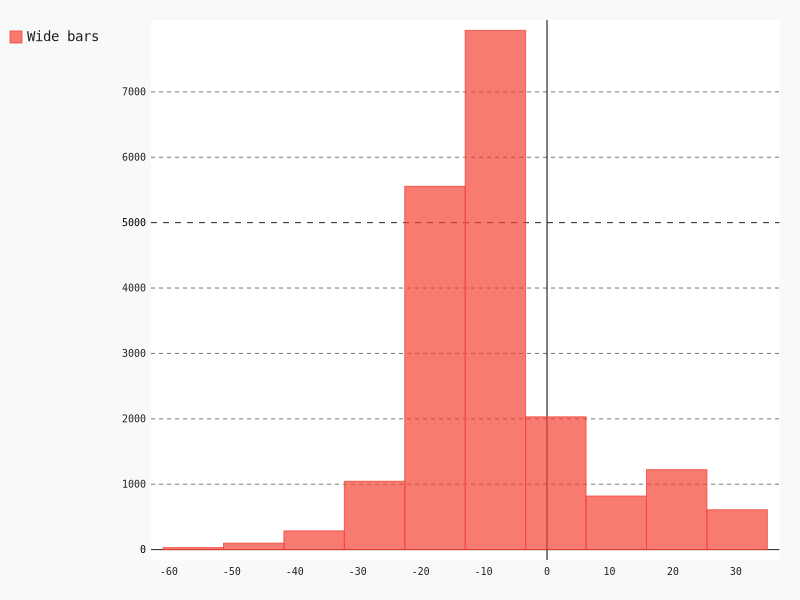

In [750]:
plot_histogram(data = X["score"])

In [752]:
X[[col, f"P_{col}"]].groupby(col).first()

,P_EDUCATION
EDUCATION,
graduate school,-1
high school,0
others,-9
university,0
unknown,-8


In [751]:
print("def qualify(feature, value):")
for i, col in enumerate(ls_best):
    if col.startswith("C_"):
        aux = X[[col, f"P_{col}"]].groupby(col).first().reset_index()
        aux["minmax"] = aux[col].str.replace("(", "").str.replace("]", "").str.split(",")
        aux["min"] = aux["minmax"].str[0].astype(float)
        aux["max"] = aux["minmax"].str[1].astype(float)
        aux["feature"] = col[2:]
        aux = aux.rename(columns={f"P_{col}": "points"})[["points", "min", "max", "feature"]]
        print(f"\tif feature == '{col[2:]}':")
        for row in aux.iterrows():
            print(f"\t\tif value >= {row[1]['min']} and value <= {row[1]['max']}:\n\t\t\treturn {row[1]['points']}")
    else:
        aux = X[[col, f"P_{col}"]].groupby(col).first().reset_index()
        aux["feature"] = col
        aux["category"] = aux[col]
        aux = aux.rename(columns={f"P_{col}": "points"})[["points", "category", "feature"]]
        print(f"\tif feature == '{col}':")
        for row in aux.iterrows():
            print(f"""\t\tif value == "{row[1]['category']}":\n\t\t\treturn {row[1]['points']}""")
    if i == 0:
        card = aux.copy()
    else:
        card = card.append(aux)

def qualify(feature, value):
	if feature == 'LIMIT_BAL':
		if value >= 108000.0 and value <= 206000.0:
			return -1
		if value >= 206000.0 and value <= 304000.0:
			return -2
		if value >= 304000.0 and value <= 402000.0:
			return -3
		if value >= 402000.0 and value <= 500000.0:
			return -4
		if value >= 9510.0 and value <= 108000.0:
			return 1
	if feature == 'PAY_AMT1':
		if value >= -55.0 and value <= 11000.0:
			return 0
		if value >= 11000.0 and value <= 22000.0:
			return 0
		if value >= 22000.0 and value <= 33000.0:
			return 0
		if value >= 33000.0 and value <= 44000.0:
			return 0
		if value >= 44000.0 and value <= 55000.0:
			return -1
	if feature == 'PAY_AMT2':
		if value >= -75.26 and value <= 15052.0:
			return 0
		if value >= 15052.0 and value <= 30104.0:
			return -6
		if value >= 30104.0 and value <= 45156.0:
			return -7
		if value >= 45156.0 and value <= 60208.0:
			return -7
		if value >= 60208.0 and value <= 75260.0:
			return -13
	if feature == 'PAY_AMT3':
		if va

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [754]:
%%time
for feat in ls_final:
    X[f"Po_{feat}"] = X[feat].apply(lambda x: qualify(feature=feat, value=x))

CPU times: user 345 ms, sys: 3.97 ms, total: 349 ms
Wall time: 349 ms


In [755]:
X["score_bis"] = X[[x for x in X.columns if x.startswith("Po_")]].sum(axis = 1)

In [756]:
X[X["score"] != X["score_bis"]]

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,SEX,EDUCATION,MARRIAGE,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PCT_USE1,PCT_PAY1,PCT_USE2,PCT_PAY2,PCT_USE3,PCT_PAY3,PCT_USE4,PCT_PAY4,PCT_USE5,PCT_PAY5,PCT_USE6,PCT_PAY6,PCT_USE_l1_mean,PCT_USE_l1_min,PCT_USE_l1_max,PCT_USE_l1_median,PCT_USE_l2_mean,PCT_USE_l2_min,PCT_USE_l2_max,PCT_USE_l2_median,PCT_USE_l3_mean,PCT_USE_l3_min,PCT_USE_l3_max,PCT_USE_l3_median,PCT_USE_l4_mean,PCT_USE_l4_min,PCT_USE_l4_max,PCT_USE_l4_median,PCT_USE_l5_mean,PCT_USE_l5_min,PCT_USE_l5_max,PCT_USE_l5_median,PCT_USE_l6_mean,PCT_USE_l6_min,PCT_USE_l6_max,PCT_USE_l6_median,PAY_AMT_l1_mean,PAY_AMT_l1_min,PAY_AMT_l1_max,PAY_AMT_l1_median,PAY_AMT_l2_mean,PAY_AMT_l2_min,PAY_AMT_l2_max,PAY_AMT_l2_median,PAY_AMT_l3_mean,PAY_AMT_l3_min,PAY_AMT_l3_max,PAY_AMT_l3_median,PAY_AMT_l4_mean,PAY_AMT_l4_min,PAY_AMT_l4_max,PAY_AMT_l4_median,PAY_AMT_l5_mean,PAY_AMT_l5_min,PAY_AMT_l5_max,PAY_AMT_l5_median,PAY_AMT_l6_mean,PAY_AMT_l6_min,PAY_AMT_l6_max,PAY_AMT_l6_median,PCT_PAY_l1_mean,PCT_PAY_l1_min,PCT_PAY_l1_max,PCT_PAY_l1_median,PCT_PAY_l2_mean,PCT_PAY_l2_min,PCT_PAY_l2_max,PCT_PAY_l2_median,PCT_PAY_l3_mean,PCT_PAY_l3_min,PCT_PAY_l3_max,PCT_PAY_l3_median,PCT_PAY_l4_mean,PCT_PAY_l4_min,PCT_PAY_l4_max,PCT_PAY_l4_median,PCT_PAY_l5_mean,PCT_PAY_l5_min,PCT_PAY_l5_max,PCT_PAY_l5_median,PCT_PAY_l6_mean,PCT_PAY_l6_min,PCT_PAY_l6_max,PCT_PAY_l6_median,C_LIMIT_BAL,C_AGE,C_BILL_AMT1,C_BILL_AMT2,C_BILL_AMT3,C_BILL_AMT4,C_BILL_AMT5,C_BILL_AMT6,C_PAY_AMT1,C_PAY_AMT2,C_PAY_AMT3,C_PAY_AMT4,C_PAY_AMT5,C_PAY_AMT6,C_PCT_USE1,C_PCT_PAY1,C_PCT_USE2,C_PCT_PAY2,C_PCT_USE3,C_PCT_PAY3,C_PCT_USE4,C_PCT_PAY4,C_PCT_USE5,C_PCT_PAY5,C_PCT_USE6,C_PCT_PAY6,C_PCT_USE_l1_mean,C_PCT_USE_l1_min,C_PCT_USE_l1_max,C_PCT_USE_l1_median,C_PCT_USE_l2_mean,C_PCT_USE_l2_min,C_PCT_USE_l2_max,C_PCT_USE_l2_median,C_PCT_USE_l3_mean,C_PCT_USE_l3_min,C_PCT_USE_l3_max,C_PCT_USE_l3_median,C_PCT_USE_l4_mean,C_PCT_USE_l4_min,C_PCT_USE_l4_max,C_PCT_USE_l4_median,C_PCT_USE_l5_mean,C_PCT_USE_l5_min,C_PCT_USE_l5_max,C_PCT_USE_l5_median,C_PCT_USE_l6_mean,C_PCT_USE_l6_min,C_PCT_USE_l6_max,C_PCT_USE_l6_median,C_PAY_AMT_l1_mean,C_PAY_AMT_l1_min,C_PAY_AMT_l1_max,C_PAY_AMT_l1_median,C_PAY_AMT_l2_mean,C_PAY_AMT_l2_min,C_PAY_AMT_l2_max,C_PAY_AMT_l2_median,C_PAY_AMT_l3_mean,C_PAY_AMT_l3_min,C_PAY_AMT_l3_max,C_PAY_AMT_l3_median,C_PAY_AMT_l4_mean,C_PAY_AMT_l4_min,C_PAY_AMT_l4_max,C_PAY_AMT_l4_median,C_PAY_AMT_l5_mean,C_PAY_AMT_l5_min,C_PAY_AMT_l5_max,C_PAY_AMT_l5_median,C_PAY_AMT_l6_mean,C_PAY_AMT_l6_min,C_PAY_AMT_l6_max,C_PAY_AMT_l6_median,C_PCT_PAY_l1_mean,C_PCT_PAY_l1_min,C_PCT_PAY_l1_max,C_PCT_PAY_l1_median,C_PCT_PAY_l2_mean,C_PCT_PAY_l2_min,C_PCT_PAY_l2_max,C_PCT_PAY_l2_median,C_PCT_PAY_l3_mean,C_PCT_PAY_l3_min,C_PCT_PAY_l3_max,C_PCT_PAY_l3_median,C_PCT_PAY_l4_mean,C_PCT_PAY_l4_min,C_PCT_PAY_l4_max,C_PCT_PAY_l4_median,C_PCT_PAY_l5_mean,C_PCT_PAY_l5_min,C_PCT_PAY_l5_max,C_PCT_PAY_l5_median,C_PCT_PAY_l6_mean,C_PCT_PAY_l6_min,C_PCT_PAY_l6_max,C_PCT_PAY_l6_median,default.payment.next.month,W_C_LIMIT_BAL,W_C_PAY_AMT1,W_C_PAY_AMT2,W_C_PAY_AMT3,W_C_PAY_AMT4,W_C_PAY_AMT5,W_C_PAY_AMT6,W_C_PAY_AMT_l1_mean,W_C_PAY_AMT_l1_min,W_C_PAY_AMT_l1_max,W_C_PAY_AMT_l1_median,W_C_PAY_AMT_l2_max,W_C_PAY_AMT_l3_max,W_C_PAY_AMT_l3_median,W_C_PAY_AMT_l4_max,W_C_PAY_AMT_l4_median,W_C_PAY_AMT_l5_max,W_C_PAY_AMT_l6_max,W_PAY_1,W_PAY_2,W_PAY_3,W_PAY_4,W_PAY_5,W_PAY_6,W_SEX,W_EDUCATION,P_C_LIMIT_BAL,P_C_PAY_AMT1,P_C_PAY_AMT2,P_C_PAY_AMT3,P_C_PAY_AMT4,P_C_PAY_AMT5,P_C_PAY_AMT6,P_C_PAY_AMT_l1_mean,P_C_PAY_AMT_l1_min,P_C_PAY_AMT_l1_max,P_C_PAY_AMT_l1_median,P_C_PAY_AMT_l2_max,P_C_PAY_AMT_l3_max,P_C_PAY_AMT_l3_median,P_C_PAY_AMT_l4_max,P_C_PAY_AMT_l4_median,P_C_PAY_AMT_l5_max,P_C_PAY_AMT_l6_max,P_PAY_1,P_PAY_2,P_PAY_3,P_PAY_4,P_PAY_5,P_PAY_6,P_SEX,P_EDUCATION,score,Po_LIMIT_BAL,Po_PAY_AMT1,Po_PAY_AMT2,Po_PAY_AMT3,Po_PAY_AMT4,Po_PAY_AMT5,Po_PAY_AMT6,Po_PAY_AMT_l1_mean,Po_PAY_AMT_l1_min,Po_PAY_AMT_l1_max,Po_PAY_AMT_l1_median,Po_PAY_AMT_l2_max,Po

In [757]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/val_default.csv")

In [758]:
df = etl_cont_pay_default(df)

In [759]:
df = etl_disc_pay_default(df)

In [760]:
df = df[ls_final + ["ID"]]

In [761]:
%%time
for feat in ls_final:
    if feat == "ID":
        continue
    df[f"P_{feat}"] = df[feat].apply(lambda x: qualify(feature=feat, value=x))

CPU times: user 231 ms, sys: 15 µs, total: 231 ms
Wall time: 229 ms


In [762]:
df["score"] = df[[x for x in df.columns if x.startswith("P_")]].sum(axis = 1)

In [763]:
df["y_hat"] = (df["score"] >= X["score"].quantile(.5))

In [764]:
df[["ID", "y_hat"]].to_csv("val_default_cs_profe.csv")

## Credit Scoring ++

In [765]:
LogisticRegression?

In [766]:
param_grid = {"penalty": ["l1", "l2"],
              "C": [x/1000 for x in range(1000)]+[0],
              "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [767]:
logreg = LogisticRegression(n_jobs=-1)

In [768]:
hp = RandomizedSearchCV(cv=4, 
                        n_iter=500,
                        param_distributions=param_grid,
                        scoring="roc_auc", 
                        verbose=10,
                        error_score=-1000, 
                        estimator=logreg, 
                        n_jobs=-1, 
                 )

In [769]:
%%time
hp.fit(X[ls_woe], y)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

CPU times: user 4.77 s, sys: 575 ms, total: 5.34 s
Wall time: 4min


RandomizedSearchCV(cv=4, error_score=-1000,
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=500, n_jobs=-1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0...0.995, 0.996, 0.997, 0.998, 0.999, 0], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=10)

In [770]:
hp.best_score_

0.7651265309637783

In [771]:
hp.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [772]:
pdo = 10
base_score = 10
base_odds = 100
factor = pdo/np.log(2)
offset = base_score - (factor - np.log(base_odds))
m = len(ls_woe)

In [773]:
alpha = lr.intercept_
betas = lr.coef_[0]

In [774]:
for feat, beta in zip(ls_woe, betas):
    X["P_" + feat[2:]] = X[feat].apply(lambda x:((beta*x + (alpha/m))*factor) + (offset/m)).astype(int)

In [775]:
X["score"] = X[[x for x in X.columns if x.startswith("P_")]].sum(axis = 1)

In [776]:
def plot_histogram(data, n_bins = 10):
    freq, bins = np.histogram(data, bins=n_bins)
    hist = pygal.Histogram()
    hist.add('Wide bars', list(zip(freq, bins, bins[1:])))
    return hist

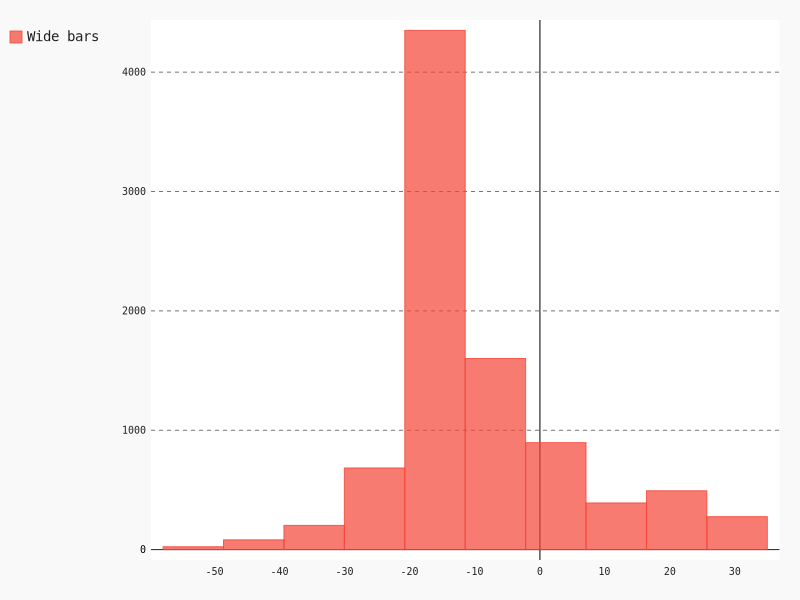

In [777]:
plot_histogram(data = df["score"])

In [778]:
print("def qualify(feature, value):")
for i, col in enumerate(ls_best):
    if col.startswith("C_"):
        aux = X[[col, f"P_{col}"]].groupby(col).first().reset_index()
        aux["minmax"] = aux[col].str.replace("(", "").str.replace("]", "").str.split(",")
        aux["min"] = aux["minmax"].str[0].astype(float)
        aux["max"] = aux["minmax"].str[1].astype(float)
        aux["feature"] = col[2:]
        aux = aux.rename(columns={f"P_{col}": "points"})[["points", "min", "max", "feature"]]
        print(f"\tif feature == '{col[2:]}':")
        for row in aux.iterrows():
            print(f"\t\tif value >= {row[1]['min']} and value <= {row[1]['max']}:\n\t\t\treturn {row[1]['points']}")
    else:
        aux = X[[col, f"P_{col}"]].groupby(col).first().reset_index()
        aux["feature"] = col
        aux["category"] = aux[col]
        aux = aux.rename(columns={f"P_{col}": "points"})[["points", "category", "feature"]]
        print(f"\tif feature == '{col}':")
        for row in aux.iterrows():
            print(f"""\t\tif value == "{row[1]['category']}":\n\t\t\treturn {row[1]['points']}""")
    if i == 0:
        card = aux.copy()
    else:
        card = card.append(aux)

def qualify(feature, value):
	if feature == 'LIMIT_BAL':
		if value >= 108000.0 and value <= 206000.0:
			return -1
		if value >= 206000.0 and value <= 304000.0:
			return -2
		if value >= 304000.0 and value <= 402000.0:
			return -3
		if value >= 402000.0 and value <= 500000.0:
			return -4
		if value >= 9510.0 and value <= 108000.0:
			return 1
	if feature == 'PAY_AMT1':
		if value >= -55.0 and value <= 11000.0:
			return 0
		if value >= 11000.0 and value <= 22000.0:
			return 0
		if value >= 22000.0 and value <= 33000.0:
			return 0
		if value >= 33000.0 and value <= 44000.0:
			return 0
		if value >= 44000.0 and value <= 55000.0:
			return -1
	if feature == 'PAY_AMT2':
		if value >= -75.26 and value <= 15052.0:
			return 0
		if value >= 15052.0 and value <= 30104.0:
			return -6
		if value >= 30104.0 and value <= 45156.0:
			return -7
		if value >= 45156.0 and value <= 60208.0:
			return -7
		if value >= 60208.0 and value <= 75260.0:
			return -13
	if feature == 'PAY_AMT3':
		if va

/home/oscar/VirtualEnvs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [779]:
def qualify(feature, value):
	if feature == 'LIMIT_BAL':
		if value >= 108000.0 and value <= 206000.0:
			return -1
		if value >= 206000.0 and value <= 304000.0:
			return -2
		if value >= 304000.0 and value <= 402000.0:
			return -3
		if value >= 402000.0 and value <= 500000.0:
			return -4
		if value >= 9510.0 and value <= 108000.0:
			return 1
	if feature == 'PAY_AMT1':
		if value >= -55.0 and value <= 11000.0:
			return 0
		if value >= 11000.0 and value <= 22000.0:
			return 0
		if value >= 22000.0 and value <= 33000.0:
			return 0
		if value >= 33000.0 and value <= 44000.0:
			return 0
		if value >= 44000.0 and value <= 55000.0:
			return -1
	if feature == 'PAY_AMT2':
		if value >= -75.26 and value <= 15052.0:
			return 0
		if value >= 15052.0 and value <= 30104.0:
			return -6
		if value >= 30104.0 and value <= 45156.0:
			return -7
		if value >= 45156.0 and value <= 60208.0:
			return -7
		if value >= 60208.0 and value <= 75260.0:
			return -13
	if feature == 'PAY_AMT3':
		if value >= -74.864 and value <= 14972.8:
			return 0
		if value >= 14972.8 and value <= 29945.6:
			return -1
		if value >= 29945.6 and value <= 44918.4:
			return -1
		if value >= 44918.4 and value <= 59891.2:
			return -2
		if value >= 59891.2 and value <= 74864.0:
			return -2
	if feature == 'PAY_AMT4':
		if value >= -69.245 and value <= 13849.0:
			return 0
		if value >= 13849.0 and value <= 27698.0:
			return -3
		if value >= 27698.0 and value <= 41547.0:
			return -4
		if value >= 41547.0 and value <= 55396.0:
			return -3
		if value >= 55396.0 and value <= 69245.0:
			return -2
	if feature == 'PAY_AMT5':
		if value >= -70.0 and value <= 14000.0:
			return 0
		if value >= 14000.0 and value <= 28000.0:
			return -6
		if value >= 28000.0 and value <= 42000.0:
			return -4
		if value >= 42000.0 and value <= 56000.0:
			return -11
		if value >= 56000.0 and value <= 70000.0:
			return -6
	if feature == 'PAY_AMT6':
		if value >= -85.75 and value <= 17150.0:
			return 0
		if value >= 17150.0 and value <= 34300.0:
			return -6
		if value >= 34300.0 and value <= 51450.0:
			return -5
		if value >= 51450.0 and value <= 68600.0:
			return -4
		if value >= 68600.0 and value <= 85750.0:
			return -6
	if feature == 'PAY_AMT_l1_mean':
		if value >= -55.0 and value <= 11000.0:
			return 0
		if value >= 11000.0 and value <= 22000.0:
			return 0
		if value >= 22000.0 and value <= 33000.0:
			return 0
		if value >= 33000.0 and value <= 44000.0:
			return 0
		if value >= 44000.0 and value <= 55000.0:
			return -1
	if feature == 'PAY_AMT_l1_min':
		if value >= -55.0 and value <= 11000.0:
			return 0
		if value >= 11000.0 and value <= 22000.0:
			return 0
		if value >= 22000.0 and value <= 33000.0:
			return 0
		if value >= 33000.0 and value <= 44000.0:
			return 0
		if value >= 44000.0 and value <= 55000.0:
			return -1
	if feature == 'PAY_AMT_l1_max':
		if value >= -55.0 and value <= 11000.0:
			return 0
		if value >= 11000.0 and value <= 22000.0:
			return 0
		if value >= 22000.0 and value <= 33000.0:
			return 0
		if value >= 33000.0 and value <= 44000.0:
			return 0
		if value >= 44000.0 and value <= 55000.0:
			return -1
	if feature == 'PAY_AMT_l1_median':
		if value >= -55.0 and value <= 11000.0:
			return 0
		if value >= 11000.0 and value <= 22000.0:
			return 0
		if value >= 22000.0 and value <= 33000.0:
			return 0
		if value >= 33000.0 and value <= 44000.0:
			return 0
		if value >= 44000.0 and value <= 55000.0:
			return -1
	if feature == 'PAY_AMT_l2_max':
		if value >= -75.26 and value <= 15052.0:
			return 0
		if value >= 15052.0 and value <= 30104.0:
			return -1
		if value >= 30104.0 and value <= 45156.0:
			return -1
		if value >= 45156.0 and value <= 60208.0:
			return -1
		if value >= 60208.0 and value <= 75260.0:
			return -3
	if feature == 'PAY_AMT_l3_max':
		if value >= -75.26 and value <= 15052.0:
			return 0
		if value >= 15052.0 and value <= 30104.0:
			return -4
		if value >= 30104.0 and value <= 45156.0:
			return -6
		if value >= 45156.0 and value <= 60208.0:
			return -6
		if value >= 60208.0 and value <= 75260.0:
			return -8
	if feature == 'PAY_AMT_l3_median':
		if value >= -53.421 and value <= 10684.2:
			return 0
		if value >= 10684.2 and value <= 21368.4:
			return 3
		if value >= 21368.4 and value <= 32052.6:
			return 5
		if value >= 32052.6 and value <= 42736.8:
			return 6
		if value >= 42736.8 and value <= 53421.0:
			return 4
	if feature == 'PAY_AMT_l4_max':
		if value >= -75.26 and value <= 15052.0:
			return 0
		if value >= 15052.0 and value <= 30104.0:
			return 0
		if value >= 30104.0 and value <= 45156.0:
			return 1
		if value >= 45156.0 and value <= 60208.0:
			return 1
		if value >= 60208.0 and value <= 75260.0:
			return 1
	if feature == 'PAY_AMT_l4_median':
		if value >= -46.95 and value <= 9390.0:
			return 0
		if value >= 18780.0 and value <= 28170.0:
			return -13
		if value >= 28170.0 and value <= 37560.0:
			return -11
		if value >= 37560.0 and value <= 46950.0:
			return -8
		if value >= 9390.0 and value <= 18780.0:
			return -6
	if feature == 'PAY_AMT_l5_max':
		if value >= -75.26 and value <= 15052.0:
			return 0
		if value >= 15052.0 and value <= 30104.0:
			return -1
		if value >= 30104.0 and value <= 45156.0:
			return -2
		if value >= 45156.0 and value <= 60208.0:
			return -2
		if value >= 60208.0 and value <= 75260.0:
			return -2
	if feature == 'PAY_AMT_l6_max':
		if value >= -85.75 and value <= 17150.0:
			return 0
		if value >= 17150.0 and value <= 34300.0:
			return 1
		if value >= 34300.0 and value <= 51450.0:
			return 1
		if value >= 51450.0 and value <= 68600.0:
			return 2
		if value >= 68600.0 and value <= 85750.0:
			return 2
	if feature == 'PAY_1':
		if value == "Non use":
			return -7
		if value == "Others":
			return 7
		if value == "pay duly":
			return -4
		if value == "payment delay for 2 months":
			return 22
		if value == "use":
			return -8
	if feature == 'PAY_2':
		if value == "Non use":
			return 0
		if value == "Others":
			return 0
		if value == "pay duly":
			return -1
		if value == "payment delay for 2 months":
			return 0
		if value == "use":
			return -1
	if feature == 'PAY_3':
		if value == "Non use":
			return -1
		if value == "Others":
			return 3
		if value == "pay duly":
			return -1
		if value == "payment delay for 2 months":
			return 2
		if value == "use":
			return -1
	if feature == 'PAY_4':
		if value == "Non use":
			return -1
		if value == "Others":
			return 3
		if value == "pay duly":
			return -1
		if value == "payment delay for 2 months":
			return 3
		if value == "use":
			return -1
	if feature == 'PAY_5':
		if value == "Non use":
			return 0
		if value == "Others":
			return 3
		if value == "pay duly":
			return -1
		if value == "payment delay for 2 months":
			return 2
		if value == "use":
			return -1
	if feature == 'PAY_6':
		if value == "Non use":
			return 0
		if value == "Others":
			return 3
		if value == "pay duly":
			return -1
		if value == "payment delay for 2 months":
			return 2
		if value == "use":
			return -1
	if feature == 'SEX':
		if value == "female":
			return -1
		if value == "male":
			return 0
	if feature == 'EDUCATION':
		if value == "graduate school":
			return -1
		if value == "high school":
			return 0
		if value == "others":
			return -9
		if value == "university":
			return 0
		if value == "unknown":
			return -8

In [780]:
%%time
for feat in ls_final:
    X[f"Po_{feat}"] = X[feat].apply(lambda x: qualify(feature=feat, value=x))

CPU times: user 309 ms, sys: 4 µs, total: 309 ms
Wall time: 309 ms


In [781]:
X["score_bis"] = X[[x for x in X.columns if x.startswith("Po_")]].sum(axis = 1)

In [783]:
df = pd.read_csv("/home/oscar/Documents/Diplomado Ciencia de Datos/Modulo 2/val_default.csv")

In [784]:
df = etl_cont_pay_default(df)

In [785]:
df = etl_disc_pay_default(df)

In [786]:
df = df[ls_final + ["ID"]]

In [787]:
%%time
for feat in ls_final:
    if feat == "ID":
        continue
    df[f"P_{feat}"] = df[feat].apply(lambda x: qualify(feature=feat, value=x))

CPU times: user 191 ms, sys: 4.03 ms, total: 195 ms
Wall time: 194 ms


In [788]:
df["score"] = df[[x for x in df.columns if x.startswith("P_")]].sum(axis = 1)

In [789]:
df["y_hat"] = (df["score"] >= X["score"].quantile(.55))

In [790]:
df[["ID", "y_hat"]].to_csv("val_default_cs++_profe.csv")